# Imports and Required Packages

In [1]:
import struct
import numpy as np
import random
import matplotlib.pyplot as plt

import keras.utils
from keras import backend as K 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras_tqdm import TQDMNotebookCallback


Using TensorFlow backend.


# Loading the Data

Our first step is to load in the data. The MNIST dataset is included with keras, so we can load it from there. Let's take a look at the distribution of the numbers in the training set

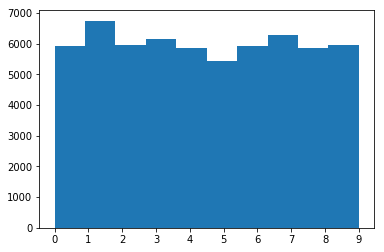

In [2]:
(x, y), (x_test, y_test) = mnist.load_data()
        
nums = range(0,10)
plt.hist(y, bins = 10)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()

# Scaling & Formatting the Data

Let's take a look at the visualizations of some of the entries. This will give us some intuition as to what we are actually doing.

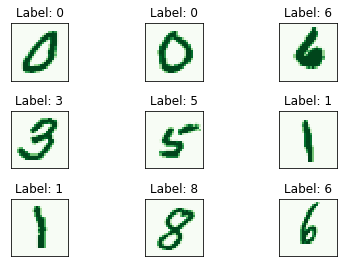

In [3]:
random.seed(2)
fig = plt.figure()
for i in range(9):
  rand = random.randint(1, 10000)
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x[i + rand], cmap='Greens', interpolation='none')
  plt.title("Label: " + str(y[i + rand]))
  plt.xticks([])
  plt.yticks([])
  

The next step is to divide the values by 255 (the largest possible value in the set). In short, this is done to improve convergence speed as well as accuracy when we build our model. This operation normalizes the data between 0 and 1.

In [4]:
x = x.astype('float')/255
x_test = x_test.astype('float')/255

Because Keras has choices in what it uses for the backend, there is a parameter that will vary here. We are using TensorFlow as the backend for this project, which expects a 4D tensor of image data as its input (just like the alternative, theano). 



In [5]:
print(K.image_data_format())

channels_last


However, there is a difference between how Theano and TensorFlow expect the data to be structured. TensorFlow uses the 'channels_last' format, while Theano uses 'channels_first'. Therefore, we will be using the channels_last version.

A 'channels_last' format has the data formatted as (samples, rows, columns, channels)

In [6]:
img_rows, img_cols = 28, 28
num_classes = 10

x = x.reshape(x.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

After refactoring the x input, we now need to get the y vector into a usable place. Our current y vector is a list of integers to represent the label for each image. We need to convert this to a list of categorical values for it to be usable in the model.

Luckily, keras.utils has this built in.

In [7]:
y = keras.utils.to_categorical(y, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Building the Model


To start building the model, we need to instantiate the Sequential class. This class represents the list of layers the model will consist of.

In [8]:
batch_size = 128
epochs = 10
verbose = 0

model = Sequential()

Now we want to decide the individual layers for the model. We will start with two 2D Convolutional layers, which is why this is a Convolutional Neural Network. These layers function moving filters passing over the image.

These layers also have an activation parameter, which is used to provide some nonlinearity to the network (pure convolution is inherently linear).

In [9]:
#Input 32 is the dimensionality of the output filters
#kernel_size is the dimension of the convolution window
#activation parameter is the type of function used to apply nonlinearity to the system.
#ReLu is used because it is less computationally expensive than tanh or sigmoid.
#ReLu converts the weights to a range of 0 to 1
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))

#The other layer input sizes are inferred from the output of the previous.
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))

#A Pooling layer is used because it drastically reduces the computational cost, while also reducing overfitting. 
model.add(MaxPooling2D(pool_size = (2, 2)))

#A dropout layer also reduces overfitting by setting a random number of activations to 0. This layer is only used in training.
model.add(Dropout(0.2))

#A flatten layer converts a matrix input into a single vector. This is because the dense layer that comes next is a classical neural net layer, 
#and requires a vector input
model.add(Flatten())

# The dense layer is a classical neural net layer with all nodes connected
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))

#The final layer requires a dimension of 10, as it has one node per possible output (0 - 9)
model.add(Dense(10, activation = 'softmax'))

model.compile(loss = categorical_crossentropy, optimizer = Adadelta(), metrics = ["accuracy"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4719104   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [ ]:
#Training the model returns a History object
#fitting requires a batch_size input, which

#Epoch is the number of iterations through the x and y data
#Changing verbose to a 1 or 2 gives some output to how the iterations of the model are doing.
#Instead of using verbose, we will be using TQDM. It provides a progress bar per epoch, with up to date information

history = model.fit(x, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=verbose,
          callbacks=[TQDMNotebookCallback()])

score = model.evaluate(x_test, y_test, verbose=0)


In [ ]:
print("Accuracy on test set: ", score[1])

plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test Data'], loc='upper left')
plt.show()

From here we have our finished model! Let's save it for later use.

In [ ]:
model.save('MNIST_Numeric_predictor.h5')